## This notebook has codes for analyses and visualizations

In [1]:
import ast
import pandas as pd
import numpy as np
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from scipy.stats import skew
from ipysankeywidget import SankeyWidget
from floweaver import *
import networkx as nx

import warnings
warnings.filterwarnings('ignore')


from Wiki_Gendersort import wiki_gendersort
WG = wiki_gendersort()
def wiki_gender_assign(df):
    firstnames = df.firstname.str.replace('Dr.', '')
    firstnames = [str(x).strip() for x in firstnames]
    df = df.assign(gender = [WG.assign(x) for x in firstnames])
    return df

#https://towardsdatascience.com/using-python-to-create-a-world-map-from-a-list-of-country-names-cd7480d03b10

#installation
#!pip install pycountry-convert

#function to convert to alpah2 country codes and continents
from pycountry_convert import country_alpha2_to_continent_code, country_name_to_country_alpha2, country_alpha2_to_country_name

def get_continent(alpha2):
    try:
        cn_name = country_alpha2_to_country_name(alpha2)
    except:
        cn_name = 'Unknown'

    try:
        cn_continent = country_alpha2_to_continent_code(alpha2)
    except:
        cn_continent = 'Unknown' 
    return (cn_name, cn_continent)

#installation
#!pip install geopy

#function to get longitude and latitude data from country name 
from geopy.geocoders import Nominatim

geolocator = Nominatim(user_agent="orcid_postdoc")
def geolocate(country):
    try:
        # Geolocate the center of the country
        loc = geolocator.geocode(country)
        # And return latitude and longitude
        return (loc.longitude, loc.latitude)
    except:
        # Return missing value
        return np.nan

### Limit analyses to the ORCID iDs whose first postdoc year is 2011 or later. 

In [2]:
dat = pd.read_csv('_dat_orcid_2022_postdoc_trajectories.csv.gz', compression='gzip')

dat.department = dat.department.astype(str)
dat.title = dat.title.astype(str)
print(dat.shape, len(set(dat.orcid)))

# This paper focuses on postdoc ORCIDs whose first postdoc year is 2011 or later. 
postdocs = dat[dat.postdoc]
first_postdocs = postdocs.groupby('orcid').head(1)
recent_postdocs = first_postdocs[first_postdocs.start_year>=2011]
recent_postdocs = list(recent_postdocs.orcid.unique())
dat = dat[dat.orcid.isin(recent_postdocs)]
print(dat.shape, len(set(dat.orcid)))

doctoral_degrees = dat.groupby('orcid').head(1)
print(doctoral_degrees.shape)

orcid_to_firstname = dict(zip(doctoral_degrees.orcid, doctoral_degrees.firstname))
orcid_to_lastname = dict(zip(doctoral_degrees.orcid, doctoral_degrees.lastname))

(445869, 15) 125364
(313044, 15) 98692
(98692, 15)


### Load Dimensions data and filter only for the recent postdocs

In [3]:
%%time
df_dimensions = pd.read_csv('_dat_orcid_2022_recent_postdocs_dimensions_publications_082123.csv').drop_duplicates()
# this file was generated from the notebook "1_postdoc_career_trajectories.ipynb". A Dimensions API key is needed.
df_dimensions.columns = ['orcid', 'pid', 'date', 'title', 'journal', 'FOR', 'citations', 'author_order']
df_dimensions = df_dimensions[df_dimensions.orcid.isin(set(recent_postdocs))]
df_dimensions.FOR = df_dimensions.FOR.apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
print(df_dimensions.shape, len(set(df_dimensions.orcid)))

(828489, 8) 51821
CPU times: user 25.3 s, sys: 996 ms, total: 26.3 s
Wall time: 26.2 s


In [4]:
print("The proportion of postdoc ORCID iDs having publication records")
round(len(set(df_dimensions.orcid))/len(set(dat.orcid))*100, 1)

The proportion of postdoc ORCID iDs having publication records


52.5

In [5]:
orcid_FOR = df_dimensions.groupby('orcid').pid.nunique().reset_index()
print(orcid_FOR.shape)
dist = orcid_FOR['pid'].value_counts().sort_index()
dist[0] = len(recent_postdocs)-len(set(df_dimensions.orcid))
dist.sort_index()

(51821, 2)


0      46871
1       7410
2       5021
3       3469
4       2715
       ...  
567        1
686        1
702        1
716        1
827        1
Name: pid, Length: 269, dtype: int64

#### For the third paragraph of Section 2.1

In [6]:
print(skew(list(orcid_FOR['pid'])))
pd.Series(list(orcid_FOR['pid'])).describe()

6.554176438770982


count    51821.000000
mean        15.986936
std         24.275452
min          1.000000
25%          3.000000
50%          8.000000
75%         20.000000
max        827.000000
dtype: float64

In [7]:
FOR_agg = df_dimensions.groupby('orcid').FOR.sum().reset_index()
orcid_FOR = orcid_FOR.assign(FOR_agg = FOR_agg.FOR.apply(lambda x: Counter([f['name'] for f in x if f['name'][2]==' '])))
orcid_FOR = orcid_FOR.assign(field = orcid_FOR.FOR_agg.apply(lambda d: [x for x in d if d[x]==max(d.values())]))

### Merge inferred academic fields with doctoral degrees

In [8]:
doctoral_degrees_w_FOR = doctoral_degrees.merge(orcid_FOR[['orcid', 'field', 'pid']], on='orcid', how='right')
doctoral_degrees_w_FOR.shape

(51821, 17)

In [9]:
cnt_orcid = 0
dist_by_field = []

for ix, row in doctoral_degrees_w_FOR[pd.isna(doctoral_degrees_w_FOR.field)].iterrows():
    cnt_orcid+=1
    dist_by_field.append((row.orcid, 'NA', row.pid))
    
for ix, row in doctoral_degrees_w_FOR[~pd.isna(doctoral_degrees_w_FOR.field)].iterrows():
    cnt_orcid+=1
    if (len(row.field)==0):
        dist_by_field.append((row.orcid, 'NA', row.pid))
    else:
        for f in row.field:
            dist_by_field.append((row.orcid, f, row.pid))
    
print(cnt_orcid)

dist_by_field = pd.DataFrame(dist_by_field, columns = ['orcid', 'field', 'n_papers'])
dist_by_field.n_papers = dist_by_field.n_papers.fillna("NA")

dist_by_field = dist_by_field[dist_by_field.field!='NA'].reset_index(drop=True)
dist_by_field

51821


,orcid,field,n_papers
0,0000-0001-5000-0584,52 Psychology,51
1,0000-0001-5000-266X,31 Biological Sciences,6
2,0000-0001-5000-3187,32 Biomedical and Clinical Sciences,50
3,0000-0001-5000-8957,31 Biological Sciences,1
4,0000-0001-5000-8957,32 Biomedical and Clinical Sciences,1
...,...,...,...
59181,0000-0003-4998-2300,42 Health Sciences,1
59182,0000-0003-4998-8585,"30 Agricultural, Veterinary and Food Sciences",1
59183,0000-0003-4999-2840,51 Physical Sciences,47
59184,0000-0003-4999-5347,31 Biological Sciences,45


In [10]:
count_all_fields = dist_by_field.field.value_counts().sort_values(ascending=False)
count_all_fields

31 Biological Sciences                           12900
32 Biomedical and Clinical Sciences              11216
40 Engineering                                    7944
34 Chemical Sciences                              7539
51 Physical Sciences                              5935
37 Earth Sciences                                 2650
46 Information and Computing Sciences             1813
52 Psychology                                     1470
42 Health Sciences                                1314
41 Environmental Sciences                         1276
30 Agricultural, Veterinary and Food Sciences     1173
49 Mathematical Sciences                           973
44 Human Society                                   873
35 Commerce, Management, Tourism and Services      372
47 Language, Communication and Culture             317
43 History, Heritage and Archaeology               301
39 Education                                       259
50 Philosophy and Religious Studies                237
33 Built E

#### Figure 1

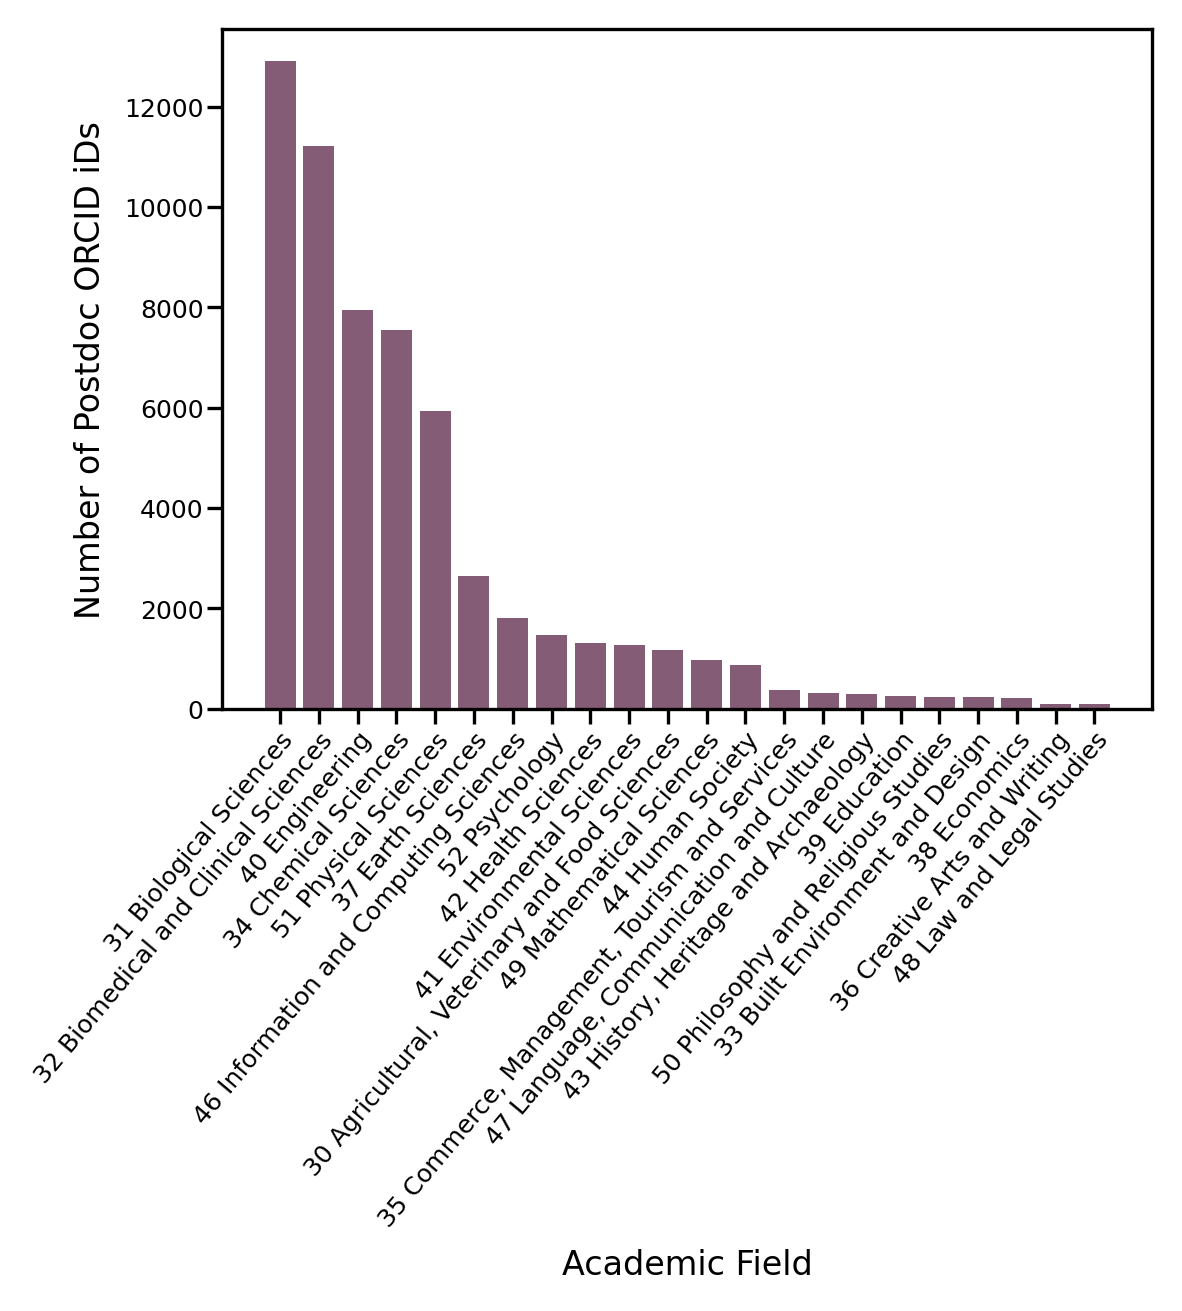

In [11]:
fig = plt.figure(figsize=(4,3), dpi=300)
ax = fig.add_subplot(111)
ax.tick_params(axis='both', which='major', pad=1)

plt.bar(count_all_fields[count_all_fields.index!="NA"].index, 
        count_all_fields[count_all_fields.index!="NA"].values, color='#855C75')
plt.xlabel("Academic Field", fontsize=8)
plt.ylabel("Number of Postdoc ORCID iDs", fontsize=8)
plt.xticks(rotation=50, rotation_mode='anchor', ha='right', fontsize=6);
plt.yticks(fontsize=6);

plt.savefig('_figs_fig1.png', bbox_inches='tight')

#### For the last paragraph of Section 2.1

In [12]:
count_by_field = dist_by_field.field.value_counts().sort_index()
count_by_field[count_by_field>5000].sort_values(ascending=False).sort_index()

31 Biological Sciences                 12900
32 Biomedical and Clinical Sciences    11216
34 Chemical Sciences                    7539
40 Engineering                          7944
51 Physical Sciences                    5935
Name: field, dtype: int64

In [13]:
selected_fields = ["31 Biological Sciences", "32 Biomedical and Clinical Sciences", 
                   "34 Chemical Sciences", "40 Engineering", "51 Physical Sciences"]
selected_fields_df = dist_by_field[dist_by_field.field.isin(selected_fields)]
print(selected_fields_df.orcid.nunique())

41318


In [14]:
orcids_with_one_paper = selected_fields_df[selected_fields_df.n_papers==1]
orcids_with_one_paper = orcids_with_one_paper.merge(dat[dat.orcid.isin(orcids_with_one_paper.orcid)][['orcid', 'department']],
                                                    on='orcid')
orcids_with_one_paper = orcids_with_one_paper[orcids_with_one_paper.department!='nan']
orcids_with_one_paper = orcids_with_one_paper[['orcid', 'field', 'department']]

concat_fields = orcids_with_one_paper.groupby('orcid').field.apply(lambda x: ','.join(set(x)))
concat_depts = orcids_with_one_paper.groupby('orcid').department.apply(lambda x: ','.join(set(x)))
concat = pd.concat([concat_fields, concat_depts], axis=1).sort_values(by=['field', 'orcid'])
print(concat.shape)

concat_sampled = concat.sample(n=100, random_state=42)
concat_sampled = concat_sampled.sort_values(by=['field'])

concat_sampled.to_csv('_dat_orcid_2022_recent_postdocs_field_assignment_validation.csv')

(5943, 2)


After having the file named "orcid_2022_recent_postdocs_field_assignment_validation.csv", the author manually compared the inferred academic fields with department names for 100 randomly sampled postdoc ORCID iDs.

### For Section 3 "Results"

In [15]:
target_dat = dat[dat.orcid.isin(selected_fields_df.orcid)]
print(target_dat.orcid.nunique())

41318


In [16]:
# for the information in Section 3.1
first_postdoc_recs = target_dat[target_dat.postdoc].groupby('orcid').head(1)
top_countries = first_postdoc_recs.groupby('country').orcid.nunique().sort_values(ascending=False).iloc[:15]
all_countries = first_postdoc_recs.groupby('country').orcid.nunique().sort_values(ascending=False)
top_countries_summary = pd.concat([top_countries, round(top_countries/target_dat[target_dat.postdoc].orcid.nunique()*100, 1)], axis=1)
print(top_countries_summary)
print(top_countries.values.sum()/all_countries.values.sum())

         orcid  orcid
country              
US       15425   37.3
GB        2398    5.8
DE        2287    5.5
CN        1604    3.9
FR        1552    3.8
IT        1524    3.7
CA        1414    3.4
ES        1356    3.3
KR        1079    2.6
CH        1058    2.6
SE         944    2.3
JP         900    2.2
AU         858    2.1
BR         828    2.0
PT         813    2.0
0.8238540103586814


In [17]:
faculty_condition = [len(x)!=0 for x in target_dat.title.str.findall(r'professor|lecturer')]
target_dat = target_dat.assign(faculty = faculty_condition)

In [18]:
df_trajectories = target_dat.groupby(['orcid'])[['country', 'inst', 'department', 'title', 'start_year', 'start_month', 'end_year', 'end_month', 'doctor', 'postdoc', 'faculty']].apply(lambda x: x.values.tolist()).reset_index()
df_trajectories.columns = ['orcid', 'trajectory']
print(df_trajectories.shape)

(41318, 2)


#### For Section 3.2.

In [19]:
idx_of_first_postdoc = []
for t in df_trajectories.trajectory:
    isPostdoc = [x[-2] for x in t]
    idx_of_first_postdoc.append(isPostdoc.index(True))

idx_of_first_postdoc = np.array(idx_of_first_postdoc)
sorted(Counter(idx_of_first_postdoc).items(), key=lambda x: x[0])

[(0, 27),
 (1, 36479),
 (2, 3935),
 (3, 650),
 (4, 157),
 (5, 45),
 (6, 12),
 (7, 6),
 (8, 1),
 (9, 2),
 (10, 2),
 (11, 1),
 (15, 1)]

In [20]:
a = sum(idx_of_first_postdoc<=1)
print(a)
print(len(df_trajectories))
print(a/len(df_trajectories))
print(len(df_trajectories)-a)

36506
41318
0.8835374413088727
4812


In [21]:
preceding_job_titles = []
for ix, row in df_trajectories.iterrows():
    if idx_of_first_postdoc[ix]<=1:
        continue
    else:
        for t in row.trajectory[1:]:
            if t[-2]:
                break
            else:
                preceding_job_titles.append((t[0], t[3]))

print("Common job titles for the first job after a doctoral degree are:")
Counter([x[1] for x in preceding_job_titles]).most_common(10)

Common job titles for the first job after a doctoral degree are:


[('research associate', 599),
 ('assistant professor', 355),
 ('research fellow', 340),
 ('research assistant', 319),
 ('researcher', 283),
 ('lecturer', 156),
 ('associate professor', 106),
 ('research scientist', 92),
 ('visiting researcher', 68),
 ('professor', 58)]

In [22]:
reduced_transitions = []
for ix, t in enumerate(df_trajectories.trajectory):
    reduced_transitions.append([df_trajectories.orcid[ix], t[0]] + t[idx_of_first_postdoc[ix]:])
print(len(reduced_transitions))

41318


In [23]:
reduced_dict = {}
for t in reduced_transitions:
    reduced_dict[t[0]] = t[1:4]

In [24]:
from collections import defaultdict
reduced_by_field = defaultdict(dict)
for s in selected_fields:
    tmp = selected_fields_df[selected_fields_df.field==s]
    for o in tmp.orcid:
        reduced_by_field[s][o] = reduced_dict[o]

### Section 3.1  - Significant international movements for the first postdoc

In [25]:
doc_to_first_postdoc_by_field = defaultdict(list)

for s in reduced_by_field:
    for o in reduced_by_field[s]:
        tmp = reduced_by_field[s][o]
        doc_to_first_postdoc_by_field[s].append((tmp[0][0], tmp[1][0]))

# print top 3 countries
for s in doc_to_first_postdoc_by_field:
    first_postdoc_countries = [x[-1] for x in doc_to_first_postdoc_by_field[s]]
    top3 = Counter(first_postdoc_countries).most_common(3)
    print(s, len(first_postdoc_countries), top3, '/', 
          round(top3[0][1]/len(first_postdoc_countries), 2))

31 Biological Sciences 12900 [('US', 5030), ('GB', 995), ('DE', 737)] / 0.39
32 Biomedical and Clinical Sciences 11216 [('US', 5091), ('GB', 692), ('IT', 430)] / 0.45
34 Chemical Sciences 7539 [('US', 2609), ('DE', 450), ('CN', 393)] / 0.35
40 Engineering 7944 [('US', 2354), ('CN', 580), ('KR', 481)] / 0.3
51 Physical Sciences 5935 [('US', 1992), ('DE', 574), ('IT', 314)] / 0.34


In [26]:
density_vec = []
doc_to_first_postdoc_elist = []
for s in doc_to_first_postdoc_by_field:
    tmp_df = pd.DataFrame(doc_to_first_postdoc_by_field[s], columns=['doc', 'first_postdoc'])
    tmp_df = tmp_df.groupby(['doc', 'first_postdoc']).size().sort_values(ascending=False).reset_index()
    tmp_df.columns = ['doc', 'first_postdoc', 'wt']
    tmp_df = tmp_df.assign(field = s)    
    doc_to_first_postdoc_elist.append(tmp_df)
    
    g = nx.from_pandas_edgelist(tmp_df.groupby(['doc', 'first_postdoc']).wt.sum().reset_index(), 'doc', 'first_postdoc')    
    print(s, g.number_of_nodes(), nx.density(g))
    density_vec.append(nx.density(g))

doc_to_first_postdoc_elist = pd.concat(doc_to_first_postdoc_elist).reset_index(drop=True)
print("\nAverage density:", np.mean(density_vec))

31 Biological Sciences 101 0.13841584158415843
32 Biomedical and Clinical Sciences 99 0.1292517006802721
34 Chemical Sciences 84 0.1629374641422834
40 Engineering 87 0.17749264902432504
51 Physical Sciences 76 0.19017543859649122

Average density: 0.15965461880550605


In [27]:
top_countries_dict = {"GB": "United Kingdom", "CN": "China",
                      "US": "United States", "FR": "France", 
                      "DE": "Germany", "IT": "Italy", "ES": "Spain", 
                      "CH": "Switzerland", "CA": "Canada", "KR": "Republic of Korea",
                      "AU": "Australia", "BR": "Brazil", "SE": "Sweden", 
                      "JP": "Japan", "PT": "Portugal"}
print(len(top_countries_dict))

doc_to_first_postdoc_elist_top = doc_to_first_postdoc_elist[doc_to_first_postdoc_elist.first_postdoc.isin(top_countries_dict.keys())]

15


In [28]:
self_loops_top = []
for field in set(doc_to_first_postdoc_elist_top.field):
    tmp = doc_to_first_postdoc_elist_top[doc_to_first_postdoc_elist_top.field==field]
    for country in sorted(set(tmp.first_postdoc)):
        self_loop_wt = tmp[(tmp.doc==country) & (tmp.first_postdoc==country)].wt.iloc[0]
        self_loop_wt_and_in_strength = tmp[(tmp.first_postdoc==country)].wt.sum()
        self_loops_top.append((field, country, 1-self_loop_wt/self_loop_wt_and_in_strength))
self_loops_top = pd.DataFrame(self_loops_top, columns=['field', 'country', 'international_postdoc_frac'])
self_loops_top.country = self_loops_top.country.replace(top_countries_dict)
self_loops_top = self_loops_top.sort_values(by=['field', 'country'])

#### Figure 2

<Figure size 1800x900 with 0 Axes>

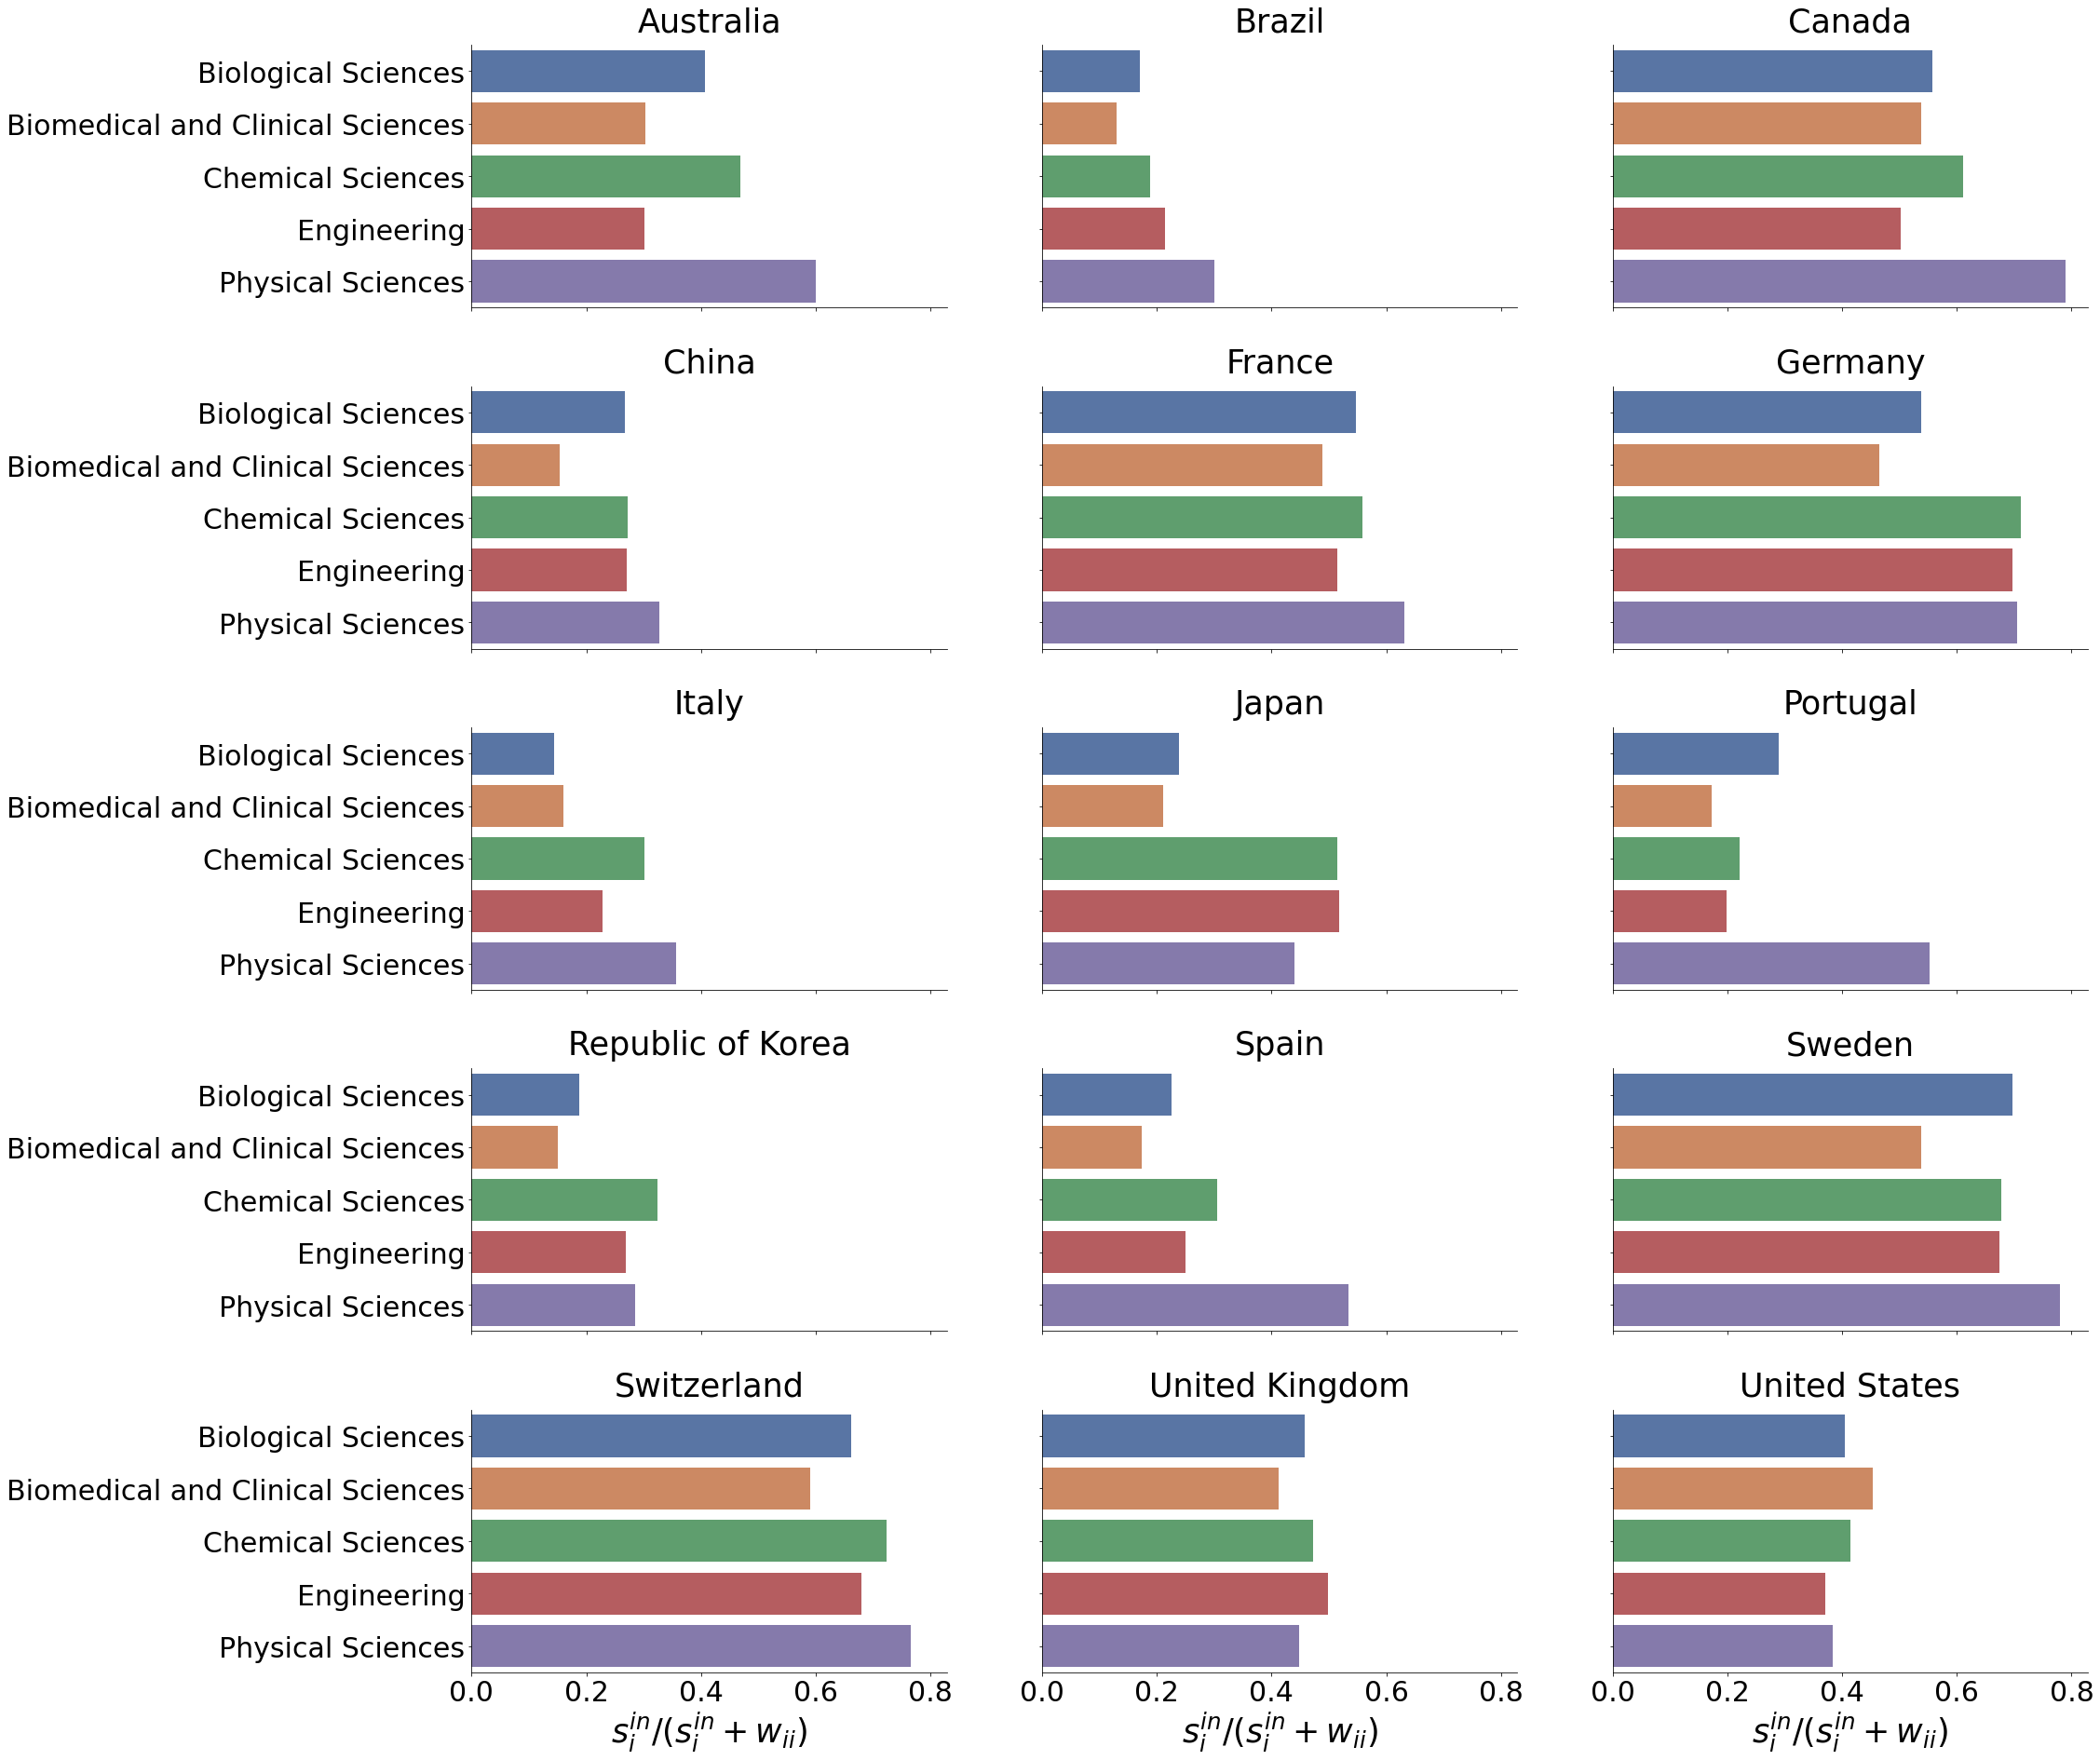

In [29]:
import seaborn as sns
plt.figure(figsize=(6,3), dpi=300)

g = sns.catplot(y="field", x="international_postdoc_frac", col="country",
                data=self_loops_top, col_wrap=3, aspect=1.8,
                kind="bar", ci=None, palette="deep", 
               col_order=sorted(top_countries_dict.values()))

g.set(xticks=[round(x, 1) for x in np.arange(0, 0.9, 0.2)])
(g.set_axis_labels(r"$s_{i}^{in}/(s_{i}^{in}+w_{ii})$", "", fontsize=35)
 .set_xticklabels([round(x, 1) for x in np.arange(0, 0.9, 0.2)], fontsize=30)
 .set_yticklabels([x[3:] for x in self_loops_top.field.unique()], fontsize=30)
 .set_titles("{col_name}", size=35, pad=15)
)

plt.subplots_adjust(hspace=0.3, wspace=0.2)
plt.savefig('_figs_fig2.png', bbox_inches='tight')

### Network backbones

In [30]:
elist_wo_self_loops= doc_to_first_postdoc_elist[doc_to_first_postdoc_elist.doc!=doc_to_first_postdoc_elist.first_postdoc]
elist_wo_self_loops= elist_wo_self_loops[['doc', 'first_postdoc', 'wt', 'field']].reset_index(drop=True)

elist_wo_self_loops.replace("VI", "US", inplace=True)
elist_wo_self_loops.replace("UM", "US", inplace=True)

#### Calculate ORCID adoption rates

In [31]:
import requests
import json

KEY = ''            # your private API key

import dimcli
dimcli.login(key=KEY,
             endpoint="https://app.dimensions.ai")

dsl = dimcli.Dsl()

Dimcli - Dimensions API Client (v1.0.2)
Connected to: <https://app.dimensions.ai/api/dsl> - DSL v2.8
Method: manual login
====
Heads up! The latest Dimcli version is  1.1
You have installed:  1.0.2
====
Please upgrade: `pip install dimcli -U`


In [32]:
# This cell is to generate a list of country names in Dimensions
query_w_orcid = f"""search organizations return country_name limit 1000"""
res = dsl.query(query_w_orcid)
df1 = res.as_dataframe()
country_names_in_dimensions = sorted(df1.id)

Returned Country_name: 228
Time: 2.47s


In [33]:
# # This cell is to collect number of researchers with or without ORCID by organization in a specific country

# for name in country_names_in_dimensions[100:]:
#     print(name)
#     try:
#         query_w_orcid = f"""search researchers where first_publication_year>=2011 
#         and (orcid_id is not empty) and current_research_org.country_name in {json.dumps([name])}
#         return current_research_org limit 1000"""
#         res = dsl.query(query_w_orcid)
#         df1 = res.as_dataframe()

#         query_for_all = f"""search researchers where first_publication_year>=2011
#         and current_research_org.country_name in {json.dumps([name])}
#         return current_research_org limit 1000"""
#         res = dsl.query(query_for_all)
#         df2 = res.as_dataframe()

#         merged = df2.merge(df1, on='id', how='left')
#         merged = merged[['id', 'name_x', 'country_name_x', 'count_x', 'count_y']].sort_values(by='count_y', ascending=False).reset_index(drop=True)

#         merged.to_csv('../dat/orcid_adoption_recent/%s.csv' % name)
        
#         time.sleep(5)
#     except:
#         continue

In [34]:
import glob
adoption_rates = dict()
files = glob.glob('../dat/orcid_adoption_recent/*')
for file in files:
    tmp = pd.read_csv(file)
    adoption_rates[tmp.country_name_x[0]] = (np.nansum(tmp.count_x), np.nansum(tmp.count_y), 
                                             np.nansum(tmp.count_y)/np.nansum(tmp.count_x))  
sorted(adoption_rates.items(), key=lambda x: x[1][0], reverse=True)[:10]

[('China', (2318888, 442233.0, 0.19070908124928845)),
 ('Japan', (514743, 83016.0, 0.16127659822474516)),
 ('Germany', (508529, 158449.0, 0.311583016897758)),
 ('Brazil', (491673, 155368.0, 0.31599864137343314)),
 ('United Kingdom', (441177, 197390.0, 0.4474167964331776)),
 ('United States', (388978, 122780.0, 0.31564767159068124)),
 ('India', (368587, 90793.0, 0.24632719005282336)),
 ('South Korea', (350592, 108934.0, 0.3107144487039065)),
 ('Spain', (311981, 123596.0, 0.3961651510829185)),
 ('Italy', (311848, 140752.0, 0.45134809266052694))]

### Matching country names across ORCID and Dimensions

In [35]:
import pycountry
print("Countries existing in ORCID but not in Dimensions\n")

for cc in set(elist_wo_self_loops.first_postdoc):
    res = pycountry.countries.get(alpha_2=cc)
    cname = res.name
    if cname not in country_names_in_dimensions:
        print(cname)

Countries existing in ORCID but not in Dimensions

Viet Nam
Côte d'Ivoire
Taiwan, Province of China
Iran, Islamic Republic of
Venezuela, Bolivarian Republic of
Korea, Republic of
Réunion
Congo, The Democratic Republic of the
Russian Federation


In [36]:
twodigits_to_name = dict()
country_names_orcid = set()
for cc in set(elist_wo_self_loops.first_postdoc):
    res = pycountry.countries.get(alpha_2=cc)
    cname = res.name
    if cname=="Viet Nam":
        cname = "Vietnam"
    if cname=="Iran, Islamic Republic of":
        cname = "Iran"
    if cname=="Congo, The Democratic Republic of the":
        cname = "Democratic Republic of the Congo"
    if cname=="Taiwan, Province of China":
        cname = "Taiwan"
    if cname=="Korea, Republic of":
        cname = "South Korea"
    if cname=="Réunion":
        cname = "Reunion"
    if cname=="Venezuela, Bolivarian Republic of":
        cname = "Venezuela"    
    if cname=="Russian Federation":
        cname = "Russia"    
        
    twodigits_to_name[cc] = cname # Côte d'Ivoire does not exist in the Dimensions org list

In [37]:
elist_wo_self_loops_adjusted = elist_wo_self_loops.copy()

v = []
countries_wo_adoption_rates = set()
for cc in elist_wo_self_loops_adjusted.first_postdoc:
    c = twodigits_to_name[cc]
    if c in adoption_rates:
        v.append(adoption_rates[c][-1])
    else: # if adoption rates are not available,set it as 1. 
        countries_wo_adoption_rates.add(c)
        v.append(1)

In [38]:
for i in range(len(elist_wo_self_loops_adjusted)):
    elist_wo_self_loops_adjusted.iloc[i, 2] /= v[i]

In [39]:
country_loc_targets = sorted(set(elist_wo_self_loops_adjusted.doc.unique()) | set(elist_wo_self_loops_adjusted.first_postdoc.unique()))
len(country_loc_targets)

119

#### Backbones with raw weights

In [40]:
# # Get longitudes and latitudes of countries

# country_loc = pd.DataFrame({'country': country_loc_targets})
# country_loc = country_loc.assign(continent = country_loc.country.apply(get_continent))
# print(len(country_loc))

# import time
# locate = []
# for c in country_loc.continent:
#     tmp = geolocate(c[0].split(',')[0])
#     locate.append(tmp)

# country_loc = country_loc.assign(locate = locate)
# #country_loc.to_csv('_dat_country_loc.csv', index=False) # Nominatim may return wrong coordinates. Manualy check is needed. 

In [41]:
country_loc = pd.read_csv('_dat_country_loc.csv')
country_loc = country_loc[~pd.isna(country_loc.locate)]

country_loc.locate = country_loc.locate.apply(ast.literal_eval)
country_loc.shape

elist_alpha = defaultdict(dict)
for s in selected_fields:
    print(s)
    tmp = elist_wo_self_loops[elist_wo_self_loops.field==s]

    src_k_out = dict(tmp.groupby('doc').first_postdoc.nunique())
    tmp = tmp.assign(src_k_out = [src_k_out[x] for x in tmp.doc])

    src_s_out = dict(tmp.groupby('doc').wt.sum())
    tmp = tmp.assign(src_s_out = [src_s_out[x] for x in tmp.doc])

    dst_k_in = dict(tmp.groupby('first_postdoc').doc.nunique())
    tmp = tmp.assign(dst_k_in = [dst_k_in[x] for x in tmp.first_postdoc])

    dst_s_in = dict(tmp.groupby('first_postdoc').wt.sum())
    tmp = tmp.assign(dst_s_in = [dst_s_in[x] for x in tmp.first_postdoc])

    tmp = tmp.assign(p = tmp.wt/tmp.src_s_out)
    tmp = tmp.assign(alpha = (1-tmp.p)**(tmp.src_k_out-1))

    elist_alpha[s] = tmp #.sort_values(by='alpha')

31 Biological Sciences
32 Biomedical and Clinical Sciences
34 Chemical Sciences
40 Engineering
51 Physical Sciences


In [42]:
th = 0.05
backbones_th = defaultdict(dict)

for s in elist_alpha:
    tmp = elist_alpha[s]
    tmp = tmp[tmp.field==s].sort_values(by='alpha')
    backbones_th[s] = tmp[tmp.alpha<th].reset_index(drop=True)

In [43]:
import networkx as nx

g_total = nx.DiGraph()
g_field = {s: nx.DiGraph() for s in backbones_th}

for s in backbones_th:
    print(s)
    for ix, row in backbones_th[s].iterrows():
        src = row.doc
        dest = row.first_postdoc
        if g_total.has_edge(src, dest):
                g_total[src][dest]['weight']+=row.wt
        else:
            g_total.add_edge(src, dest, weight=row.wt)
                
        if g_field[s].has_edge(src, dest):
            g_field[s][src][dest]['weight']+=row.wt
        else:
            g_field[s].add_edge(src, dest, weight=row.wt)

31 Biological Sciences
32 Biomedical and Clinical Sciences
34 Chemical Sciences
40 Engineering
51 Physical Sciences


#### Figure 3

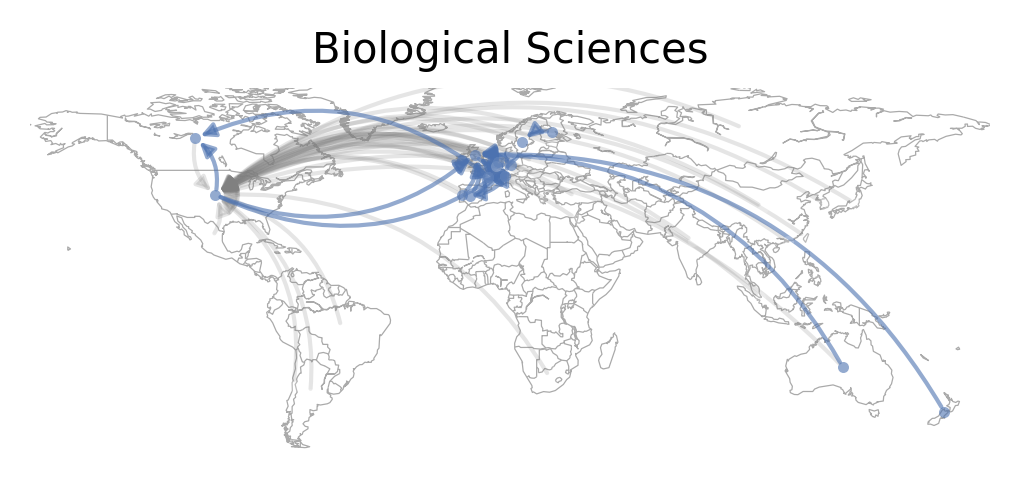

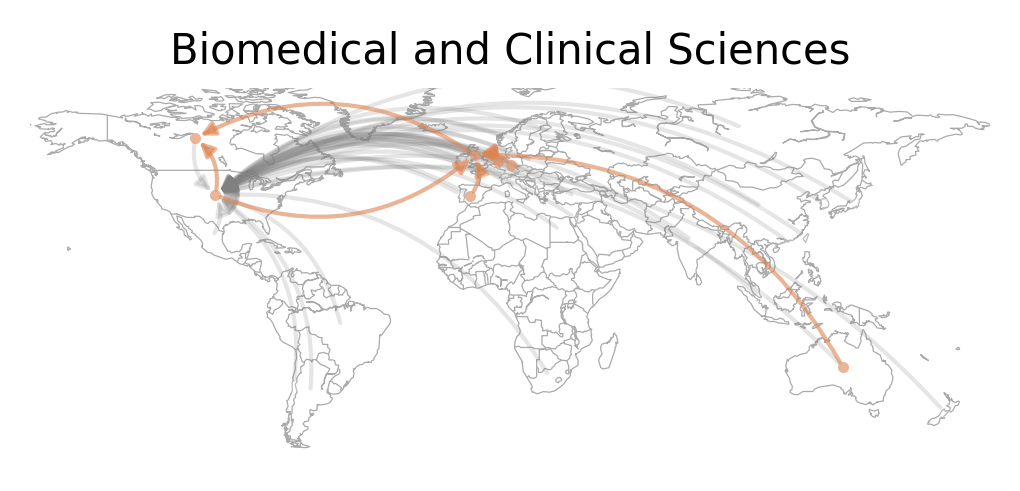

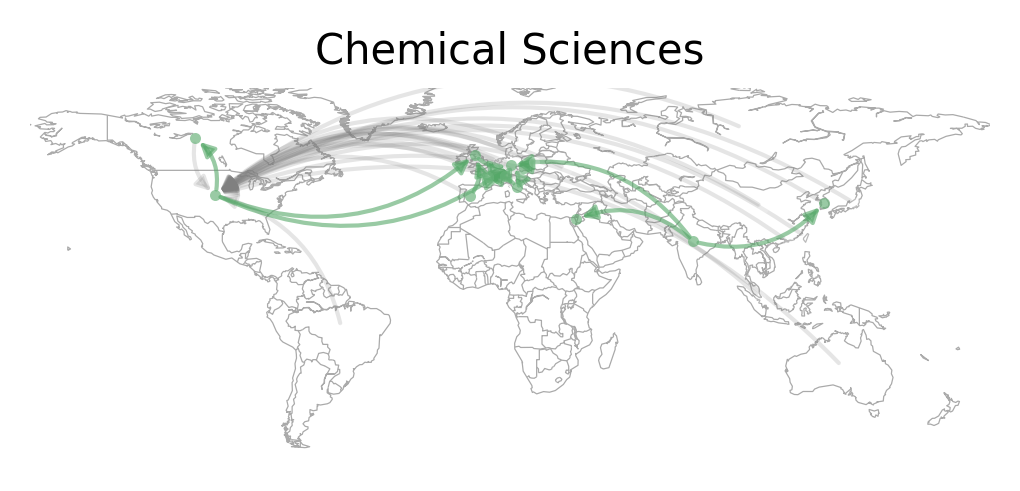

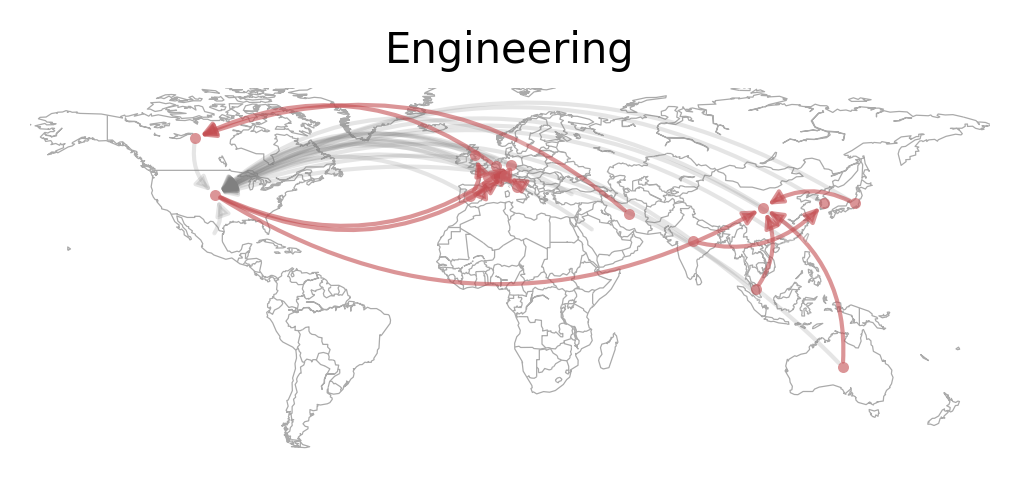

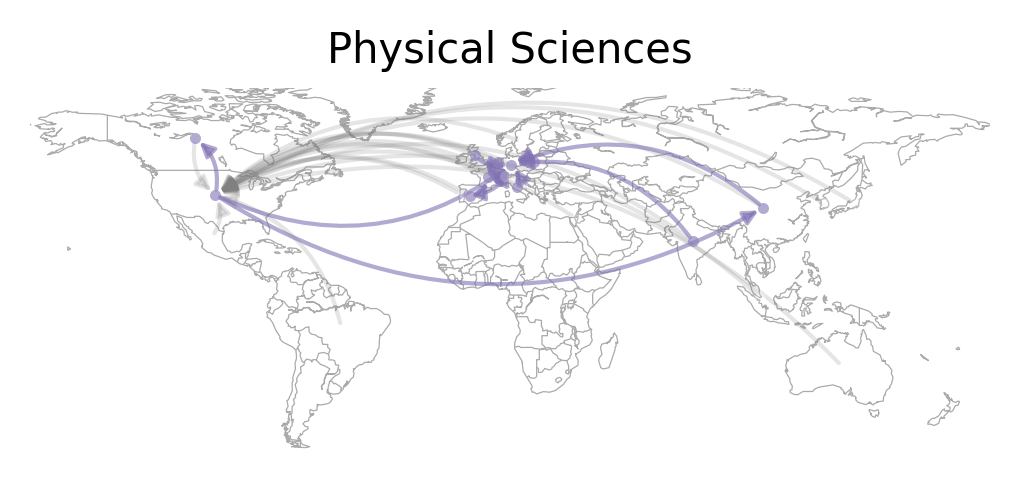

In [44]:
from mpl_toolkits.basemap import Basemap as Basemap
import copy
import seaborn as sns

pal = sns.color_palette('deep')
pal = pal.as_hex()

for ix, s in enumerate(g_field.keys()):
    g_target = g_field[s]
    g_to_us = g_target.edge_subgraph([edge for edge in g_target.edges if edge[1]=="US"])
    g_to_non_us = g_target.edge_subgraph([edge for edge in g_target.edges if edge[1]!="US"])
    
    country_loc_tmp = country_loc[country_loc.country.isin(g_target.nodes())]   
    
    plt.figure(figsize = (3.5,3), dpi=300)
    m = Basemap(
        projection='cyl',
        llcrnrlon=-170,
        llcrnrlat=-60,
        urcrnrlon=+190,
        urcrnrlat=80,
        lat_ts=0,
        resolution='c',
        area_thresh=10000,
        suppress_ticks=True)
    
    pos = [m(x[0], x[1]) for x in country_loc_tmp.locate]
    pos = dict(zip(country_loc_tmp.country, pos))

    m.drawcountries(linewidth = .3, color='#aaaaaa', zorder=0)
    m.drawcoastlines(linewidth= .3, color='#aaaaaa', zorder=0)
    
    nx.draw(g_to_us, pos, node_size=7, node_color='#FFFFFFAA', linewidths=0, alpha=0.2, 
           edge_color='gray', arrowsize=7, connectionstyle='Arc3, rad=0.3')
    
    nx.draw(g_to_non_us, pos, node_size=7, node_color=pal[ix], linewidths=0, alpha=0.6, 
           edge_color=pal[ix], arrowsize=7, connectionstyle='Arc3, rad=0.3')

    plt.title(s[3:], fontsize=10)
    plt.tight_layout()
    plt.savefig('_figs_backbone_raw_%s.png' % (s), bbox_inches='tight')

### Backbones with $w_{adj}$

In [45]:
elist_alpha_adj = defaultdict(dict)
for s in selected_fields:
    print(s)
    tmp = elist_wo_self_loops_adjusted[elist_wo_self_loops_adjusted.field==s]

    src_k_out = dict(tmp.groupby('doc').first_postdoc.nunique())
    tmp = tmp.assign(src_k_out = [src_k_out[x] for x in tmp.doc])

    src_s_out = dict(tmp.groupby('doc').wt.sum())
    tmp = tmp.assign(src_s_out = [src_s_out[x] for x in tmp.doc])

    dst_k_in = dict(tmp.groupby('first_postdoc').doc.nunique())
    tmp = tmp.assign(dst_k_in = [dst_k_in[x] for x in tmp.first_postdoc])

    dst_s_in = dict(tmp.groupby('first_postdoc').wt.sum())
    tmp = tmp.assign(dst_s_in = [dst_s_in[x] for x in tmp.first_postdoc])

    tmp = tmp.assign(p = tmp.wt/tmp.src_s_out)
    tmp = tmp.assign(alpha = (1-tmp.p)**(tmp.src_k_out-1))

    elist_alpha_adj[s] = tmp #.sort_values(by='alpha')

31 Biological Sciences
32 Biomedical and Clinical Sciences
34 Chemical Sciences
40 Engineering
51 Physical Sciences


In [46]:
th = 0.05
backbones_th_adj = defaultdict(dict)

for s in elist_alpha_adj:
    tmp = elist_alpha_adj[s]
    tmp = tmp[tmp.field==s].sort_values(by='alpha')
    backbones_th_adj[s] = tmp[tmp.alpha<th].reset_index(drop=True)

In [47]:
import networkx as nx

g_total_adj = nx.DiGraph()
g_field_adj = {s: nx.DiGraph() for s in backbones_th}

for s in backbones_th_adj:
    print(s)
    for ix, row in backbones_th_adj[s].iterrows():
        src = row.doc
        dest = row.first_postdoc
        if g_total_adj.has_edge(src, dest):
                g_total_adj[src][dest]['weight']+=row.wt
        else:
            g_total_adj.add_edge(src, dest, weight=row.wt)
                
        if g_field_adj[s].has_edge(src, dest):
            g_field_adj[s][src][dest]['weight']+=row.wt
        else:
            g_field_adj[s].add_edge(src, dest, weight=row.wt)

31 Biological Sciences
32 Biomedical and Clinical Sciences
34 Chemical Sciences
40 Engineering
51 Physical Sciences


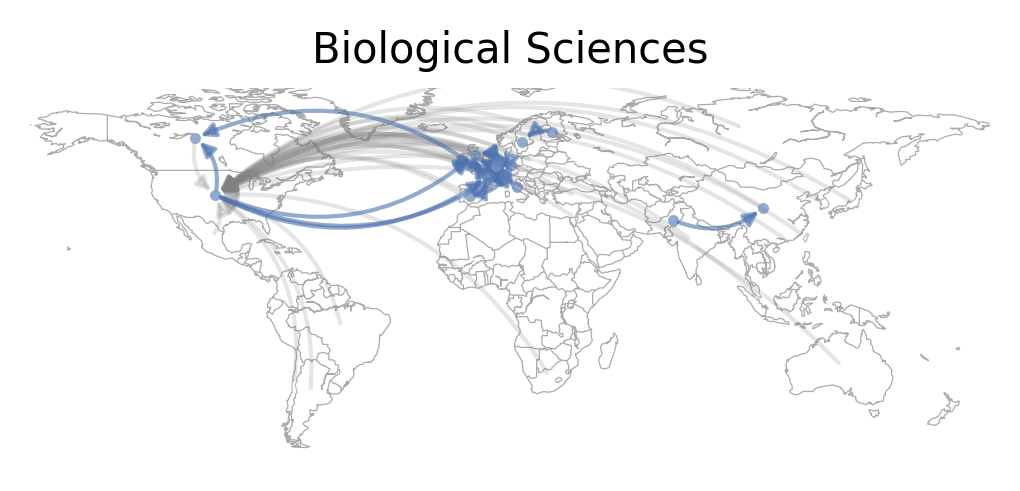

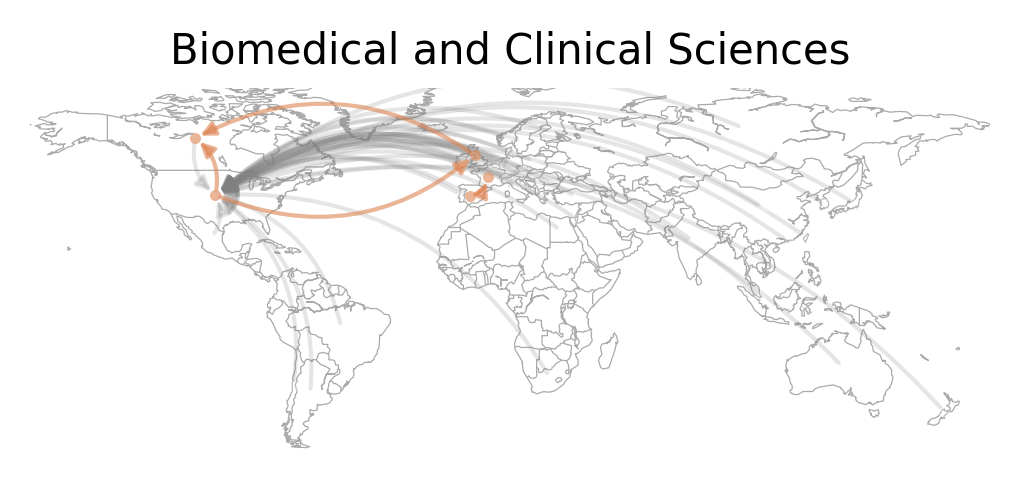

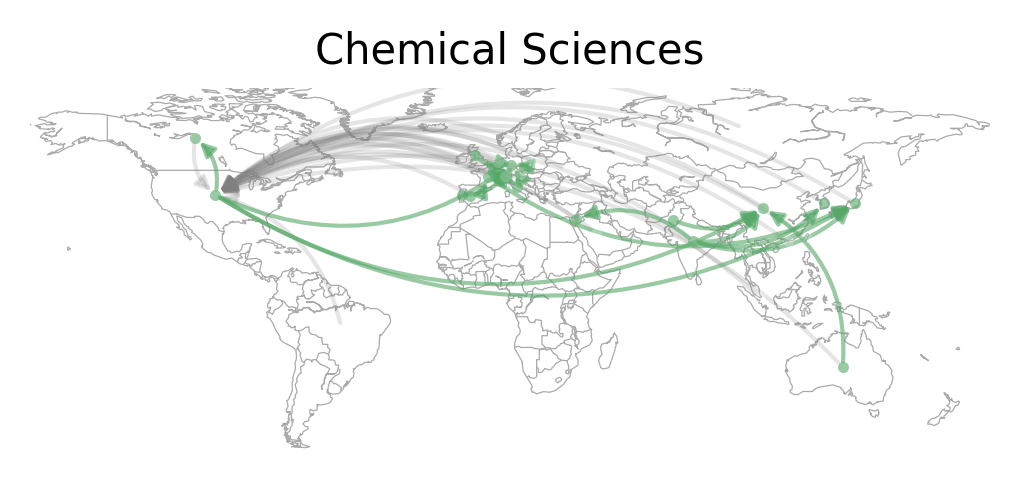

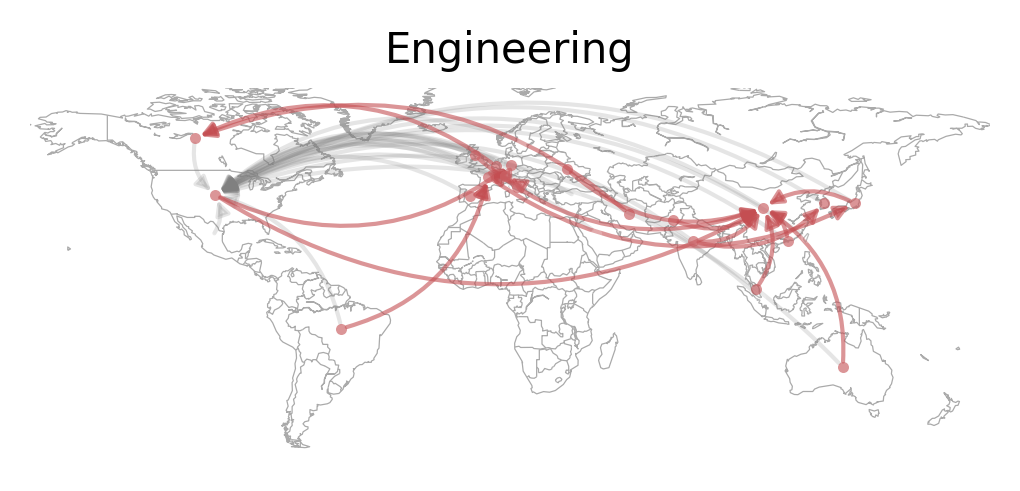

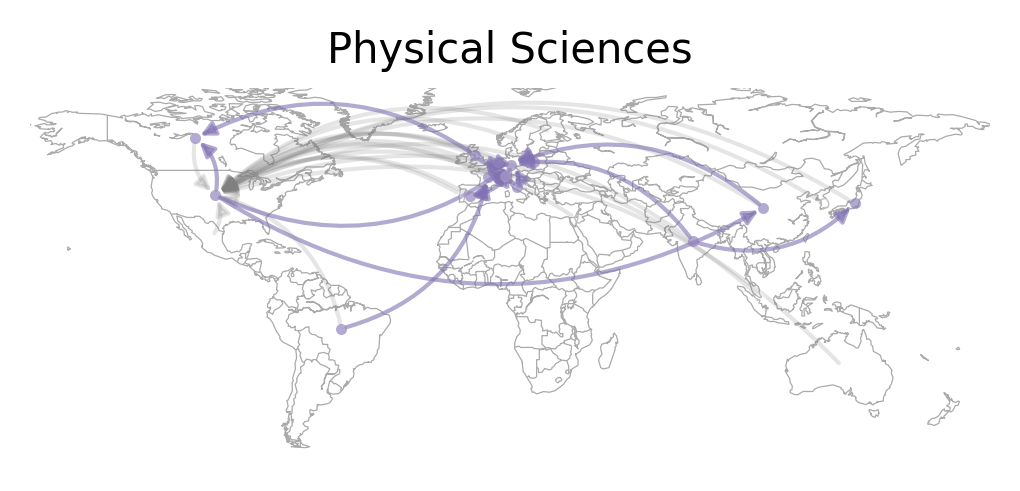

In [48]:
from mpl_toolkits.basemap import Basemap as Basemap
import copy
import seaborn as sns

pal = sns.color_palette('deep')
pal = pal.as_hex()

for ix, s in enumerate(g_field_adj.keys()):
    g_target = g_field_adj[s]
    g_to_us = g_target.edge_subgraph([edge for edge in g_target.edges if edge[1]=="US"])
    g_to_non_us = g_target.edge_subgraph([edge for edge in g_target.edges if edge[1]!="US"])
    
    country_loc_tmp = country_loc[country_loc.country.isin(g_target.nodes())]   
    
    plt.figure(figsize = (3.5,3), dpi=300)
    m = Basemap(
        projection='cyl',
        llcrnrlon=-170,
        llcrnrlat=-60,
        urcrnrlon=+190,
        urcrnrlat=80,
        lat_ts=0,
        resolution='c',
        area_thresh=10000,
        suppress_ticks=True)
    
    pos = [m(x[0], x[1]) for x in country_loc_tmp.locate]
    pos = dict(zip(country_loc_tmp.country, pos))

    m.drawcountries(linewidth = .3, color='#aaaaaa', zorder=0)
    m.drawcoastlines(linewidth= .3, color='#aaaaaa', zorder=0)
    
    nx.draw(g_to_us, pos, node_size=7, node_color='#FFFFFFAA', linewidths=0, alpha=0.2, 
           edge_color='gray', arrowsize=7, connectionstyle='Arc3, rad=0.3')
    
    nx.draw(g_to_non_us, pos, node_size=7, node_color=pal[ix], linewidths=0, alpha=0.6, 
           edge_color=pal[ix], arrowsize=7, connectionstyle='Arc3, rad=0.3')

    plt.title(s[3:], fontsize=10)
    plt.tight_layout()
    plt.savefig('_figs_backbone_adj_%s.png' % (s), bbox_inches='tight')

# Section 3.2

#### Table 1

In [49]:
type_df = []
for s in reduced_by_field:
    type_dist = []    
    for x in reduced_by_field[s]:
        type_info = []
        for r in reduced_by_field[s][x]:
            type_info.append(r[-3:])
        
        if len(type_info)==2:
            t = "First Postdoc"
        else:
            t = "NotDecidedYet"
            if type_info[-1][-2]==1:
                t = "Second Postdoc"
            if (type_info[-1][-2]==0) and (type_info[-1][-1]==0):
                t = "Non-Faculty"
            if (type_info[-1][-2]==0) and (type_info[-1][-1]==1):
                t = "Faculty"
        type_dist.append(t)
    tmp = pd.DataFrame({'orcid': list(reduced_by_field[s].keys()), 'field': s, 'TYPE': type_dist, 
                        'job_title': [reduced_by_field[s][x][-1][3] for x in reduced_by_field[s]]})
    
    print(s)
    type_df.append(tmp)
    
type_df = pd.concat(type_df, axis=0)

ct = pd.crosstab(type_df.field, type_df.TYPE)[['Second Postdoc', 'Non-Faculty', 'Faculty']]
print(ct.sum(axis=1))
print('===\n',ct)

(ct.div(ct.sum(axis=1), axis=0).round(2)*100)

31 Biological Sciences
32 Biomedical and Clinical Sciences
34 Chemical Sciences
40 Engineering
51 Physical Sciences
field
31 Biological Sciences                 7792
32 Biomedical and Clinical Sciences    6534
34 Chemical Sciences                   4886
40 Engineering                         5098
51 Physical Sciences                   3861
dtype: int64
===
 TYPE                                 Second Postdoc  Non-Faculty  Faculty
field                                                                    
31 Biological Sciences                         3765         2707     1320
32 Biomedical and Clinical Sciences            2914         2434     1186
34 Chemical Sciences                           2305         1502     1079
40 Engineering                                 1867         1722     1509
51 Physical Sciences                           1988         1281      592


TYPE,Second Postdoc,Non-Faculty,Faculty
field,,,
31 Biological Sciences,48.0,35.0,17.0
32 Biomedical and Clinical Sciences,45.0,37.0,18.0
34 Chemical Sciences,47.0,31.0,22.0
40 Engineering,37.0,34.0,30.0
51 Physical Sciences,51.0,33.0,15.0


## First postdoc to second postdoc

In [50]:
reduced_by_field_unnested = dict()
for field in reduced_by_field:
    for o in reduced_by_field[field]:
        reduced_by_field_unnested[o] = reduced_by_field[field][o]
print(len(reduced_by_field_unnested))

41318


In [51]:
summarized = []
for field in selected_fields:
    for tr_type in ['Second Postdoc', 'Non-Faculty', 'Faculty']:
        for o in type_df[(type_df.field==field) & (type_df.TYPE==tr_type)].orcid:
            x = reduced_by_field_unnested[o]
            summarized.append([o, field, tr_type]+[r[0] for r in x[:3]])

summarized = pd.DataFrame(summarized, columns=['orcid', 'field', 'tr_type', 'doc', 'first_postdoc', 'target'])
summarized.head()

,orcid,field,tr_type,doc,first_postdoc,target
0,0000-0001-5007-6896,31 Biological Sciences,Second Postdoc,GB,GB,AU
1,0000-0001-5007-7469,31 Biological Sciences,Second Postdoc,KR,KR,DE
2,0000-0001-5009-5798,31 Biological Sciences,Second Postdoc,IT,IT,IT
3,0000-0001-5010-8560,31 Biological Sciences,Second Postdoc,PT,PT,PT
4,0000-0001-5015-644X,31 Biological Sciences,Second Postdoc,US,DE,GB


In [52]:
flows= summarized.groupby(['doc', 'field', 'first_postdoc', 'tr_type', 'target']).size().reset_index()
flows.columns = ['source', 'field', 'first_postdoc', 'tr_type', 'target', 'value']
flows.field = [x[3:] for x in flows.field]
flows.field = flows.field.replace("Biomedical and Clinical Sciences", "Biomedical and \nClinical Sciences")
flows.head()

,source,field,first_postdoc,tr_type,target,value
0,AE,Chemical Sciences,AE,Non-Faculty,AE,1
1,AE,Engineering,CA,Non-Faculty,CA,1
2,AM,Chemical Sciences,US,Non-Faculty,KR,1
3,AM,Engineering,US,Faculty,AM,1
4,AR,Biological Sciences,AR,Faculty,AR,1


#### Figure 4

In [53]:
import time
# https://floweaver.readthedocs.io/en/latest/tutorials/quickstart.html

country_of_interest = "KR"
test = flows[flows.source.isin([country_of_interest])]

uniq_src = list(test.source.unique())
uniq_target = list(test.target.unique())
uniq_all = list(np.unique(test[['source', 'first_postdoc', 'target']].values))

uniq_field = sorted(flows.field.unique())
uniq_p1 = list(test.first_postdoc.unique())
uniq_tr_type = ['Second Postdoc', 'Non-Faculty', 'Faculty']

# country groups
others = [c for c in uniq_all if c not in top_countries.index]
country_groups = []
for c in top_countries_dict:
    country_groups.append((top_countries_dict[c], [c]))
country_groups.append(("Others", others))

partition_by_field = Partition.Simple('field', uniq_field)
partition_by_p1 = Partition.Simple('first_postdoc', country_groups)
partition_by_trtype= Partition.Simple('tr_type', uniq_tr_type)


size = dict(width=1200, height=500)

nodes = {
    'doc': ProcessGroup(uniq_src, title='Doctorate'),
    'field': Waypoint(partition_by_field, title='Inferred Field'),
    'p1': Waypoint(partition_by_p1, title='First Postdoc'),
    'trtype': Waypoint(partition_by_trtype, title='Transition'),
    'p2': ProcessGroup(uniq_target, title='Destination'),    
}

ordering = [
    ['doc'],
    ['field'],
    ['p1'],
    ['trtype'],
    ['p2'],
]

bundles = [
    Bundle('doc', 'p2', waypoints=['field', 'p1', 'trtype']),
]


nodes['doc'].partition = Partition.Simple('process', country_groups)
nodes['p2'].partition = Partition.Simple('process', country_groups)

pal = sns.color_palette('pastel', desat=0.6)
pal = pal.as_hex()
pal = {x: pal[ix] for ix, x in enumerate(selected_fields)}

sdd = SankeyDefinition(nodes, bundles, ordering, flow_partition=partition_by_field)

s = weave(sdd, test, palette=pal).to_widget(**size)
s

SankeyWidget(groups=[{'id': 'doc', 'type': 'process', 'title': 'Doctorate', 'nodes': ['doc^Republic of Korea']…

In [54]:
# print(country_of_interest)
# s.save_png('../figs/alluvial/alluvial_%s.png' % country_of_interest)

### Gender differences

In [55]:
def wiki_gender_assign(df):
    firstnames = df.firstname.str.replace('Dr.', '')
    firstnames = [str(x).strip() for x in firstnames]
    df = df.assign(gender = [WG.assign(x) for x in firstnames])
    return df

In [56]:
summarized = summarized.assign(firstname = [orcid_to_firstname[o] for o in summarized.orcid])
summarized = wiki_gender_assign(summarized).reset_index(drop=True)

#### Table 2

In [57]:
tab2 = summarized[['orcid', 'doc', 'gender']].drop_duplicates().groupby(['doc','gender']).size().unstack(fill_value=0)
tab2 = tab2[tab2.index.isin(top_countries_dict.keys())]
tab2[["F", "M", "UNK", "UNI", "INI"]]

gender,F,M,UNK,UNI,INI
doc,,,,,
AU,170,303,54,33,1
BR,255,441,46,4,2
CA,186,488,60,18,1
CH,136,286,17,14,1
CN,257,941,491,316,10
DE,267,665,62,33,0
ES,619,853,22,10,3
FR,399,826,54,32,0
GB,554,1108,75,62,3


In [58]:
st = summarized.copy()
st = st[st.doc.isin(top_countries_dict.keys())]
st = st[st.doc!="US"]

p_type = []
for ix, row in st.iterrows():
    tc = row.doc
    if (row.first_postdoc=="US") & (row.target=="US"):
        p_type.append("P0")
    elif (row.first_postdoc=="US") & (row.target==tc):
        p_type.append("P1")
    elif (row.first_postdoc=="US") & (row.target not in ["US", tc]):
        p_type.append("P2")
    elif (row.first_postdoc==tc) & (row.target=="US"):
        p_type.append("P3")
    elif (row.first_postdoc==tc) & (row.target==tc):
        p_type.append("P4")
    elif (row.first_postdoc==tc) & (row.target not in ["US", tc]):
        p_type.append("P5")
    elif (row.first_postdoc not in ["US", tc]) & (row.target=="US"):
        p_type.append("P6")
    elif (row.first_postdoc not in ["US", tc]) & (row.target==tc):
        p_type.append("P7")
    elif (row.first_postdoc not in ["US", tc]) & (row.first_postdoc==row.target):
        p_type.append("P8")
    elif (row.first_postdoc not in ["US", tc]) & (row.target not in ["US", tc, row.first_postdoc]):
        p_type.append("P9")
    else:
        p_type.append("")

In [59]:
st = st.assign(p_type = p_type)
st.p_type.value_counts().sort_index()

P0    1581
P1     994
P2     450
P3    1114
P4    4423
P5    2363
P6     332
P7    1417
P8    1566
P9    1147
Name: p_type, dtype: int64

In [60]:
st.doc = st.doc.replace(top_countries_dict)
st.first_postdoc = st.first_postdoc.replace(top_countries_dict)
st.target = st.target.replace(top_countries_dict)

In [61]:
st_tab = st[st.gender.isin(['F', 'M'])].groupby(['doc','field','tr_type','gender','p_type']).size().unstack(fill_value=0)
st_tab = st_tab.sort_index(ascending=[True, True, False, True])

In [62]:
st_tab.iloc[:6]

p_type                                                  P0  P1  P2  P3  P4  \
doc       field                  tr_type        gender                       
Australia 31 Biological Sciences Second Postdoc F        1   1   2   5   6   
                                                M        2   3   0   6   7   
                                 Non-Faculty    F        5   2   1   0  15   
                                                M        5   3   1   1  12   
                                 Faculty        F        0   0   1   0   1   
                                                M        2   1   0   0   1   

p_type                                                  P5  P6  P7  P8  P9  
doc       field                  tr_type        gender                      
Australia 31 Biological Sciences Second Postdoc F        5   2   1   4   1  
                                                M        5   3   3   8   8  
                                 Non-Faculty    F        3   0   2   1   2  
                                                M        2   0   7   5   1  
                                 Faculty        F        1   0   0   3   1  
                                                M        2   0   0   4   2

In [63]:
#https://www.geeksforgeeks.org/python-pearsons-chi-square-test/
from scipy.stats import chi2_contingency
freq_th=20

p_values = []
for c in sorted(st.doc.unique()):
    for field in st.field.unique():
        for t in st.tr_type.unique():                
            try:
                v_f = st_tab.loc[c].loc[field].loc[t].loc["F"].values
            except:
                v_f = np.array([0]*10)
            try:
                v_m = st_tab.loc[c].loc[field].loc[t].loc["M"].values
            except:
                v_m = np.array([0]*10)
            v = np.array([v_f, v_m]).astype(float)
     
            v[v==0]=0.0000001 # a small hack to conduct statistical tests.
            
            stat, p, dof, expected = chi2_contingency(v)
            p_values.append((c, field, t, round(p, 3), int(v[0].sum()), int(v[1].sum())))

            if (round(p, 3)<0.05) & (v[0].sum()>=freq_th) & (v[1].sum()>=freq_th):
                print(c, field, t)
                print(np.round(v),'\n')
                print(np.round(v-expected)[0], '\n')

Brazil 32 Biomedical and Clinical Sciences Second Postdoc
[[ 4.  3.  3. 10. 10. 14.  2.  7.  7.  0.]
 [10.  0.  1. 20. 15.  5.  2.  2.  3.  2.]] 

[-3.  1.  1. -5. -2.  4.  0.  2.  2. -1.] 

Italy 31 Biological Sciences Second Postdoc
[[ 3.  1.  0. 11. 57. 14.  1.  5. 13.  6.]
 [ 2.  0.  3. 10. 24. 21.  4.  4.  8.  5.]] 

[ 0.  0. -2. -1. 10. -6. -2. -0.  1. -0.] 



#### Table 3

In [64]:
p_values = pd.DataFrame(p_values, columns=['country', 'field', 'tr_type', 'pvalue', 'f_count', 'm_count'])
p_values

,country,field,tr_type,pvalue,f_count,m_count
0,Australia,31 Biological Sciences,Second Postdoc,0.539,28,45
1,Australia,31 Biological Sciences,Non-Faculty,0.633,31,37
2,Australia,31 Biological Sciences,Faculty,0.927,7,12
3,Australia,32 Biomedical and Clinical Sciences,Second Postdoc,0.859,39,32
4,Australia,32 Biomedical and Clinical Sciences,Non-Faculty,0.224,31,29
...,...,...,...,...,...,...
205,United Kingdom,40 Engineering,Non-Faculty,0.642,19,73
206,United Kingdom,40 Engineering,Faculty,0.261,9,25
207,United Kingdom,51 Physical Sciences,Second Postdoc,0.257,28,127
208,United Kingdom,51 Physical Sciences,Non-Faculty,0.265,29,101


In [65]:
p_values[(p_values.m_count>=freq_th) & (p_values.f_count>=freq_th)]

,country,field,tr_type,pvalue,f_count,m_count
0,Australia,31 Biological Sciences,Second Postdoc,0.539,28,45
1,Australia,31 Biological Sciences,Non-Faculty,0.633,31,37
3,Australia,32 Biomedical and Clinical Sciences,Second Postdoc,0.859,39,32
4,Australia,32 Biomedical and Clinical Sciences,Non-Faculty,0.224,31,29
15,Brazil,31 Biological Sciences,Second Postdoc,0.384,55,77
...,...,...,...,...,...,...
200,United Kingdom,32 Biomedical and Clinical Sciences,Faculty,0.298,26,36
201,United Kingdom,34 Chemical Sciences,Second Postdoc,0.717,33,92
202,United Kingdom,34 Chemical Sciences,Non-Faculty,0.123,30,82
207,United Kingdom,51 Physical Sciences,Second Postdoc,0.257,28,127


In [66]:
p_values[(p_values.m_count>=freq_th) & (p_values.f_count>=freq_th)].country.unique()

array(['Australia', 'Brazil', 'Canada', 'China', 'France', 'Germany',
       'Italy', 'Portugal', 'Spain', 'Sweden', 'Switzerland',
       'United Kingdom'], dtype=object)

In [67]:
p_values[(p_values.pvalue<0.05) & (p_values.m_count>=freq_th) & (p_values.f_count>=freq_th)]

,country,field,tr_type,pvalue,f_count,m_count
18,Brazil,32 Biomedical and Clinical Sciences,Second Postdoc,0.010,60,60
90,Italy,31 Biological Sciences,Second Postdoc,0.035,111,81
